# Analyzing Vegas Line Shifts for MLB

### Introduction

   Markets can be considered competitive arenas where a number of participants strive to find a profitable price for a commodity. A popular example of a market is the stock market - a company opens a stock with an IPO, and the market places money on whether or not they believe the stock is appropriately priced. This causes the stock's price to fluctuate through a given period of time until the closing bell.
   
   Vegas sportsbooks are sometimes misclassified as simply a gambling entity rather than a sophisticated marketplace. Similar to the stockmarket, sportsbooks will release opening odds for a team's probability to win a game, and then the market of bettors will place money on whether or not they believe the team will win the game. This causes a team's odds to fluctuate through a given period of time until the beginning of the game.
   
   The recent AI boom has given both the sportsbooks and highly educated bettors the ability to accurately set odds based on a team's probability to win. But how much has Vegas and its associate sportsbooks evolved? Is Vegas's prediction model more accurate than the market? I'll be exploring Vegas odds and line movements to determine whether or not the modern market is tougher than the old markets.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plotFunctions
import seaborn

seaborn.set(rc = {"axes.facecolor" : seaborn.xkcd_rgb["light grey"], "figure.facecolor" : seaborn.xkcd_rgb["light grey"]})

In [11]:
vegasData = pd.read_csv("MLB Pinnacle Lines Data.csv")
'''Warning below is upset that some times are strings, and some times are the float value "None"'''

c:\users\nczea\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (16,19,22,25,28,31,34,37,40,43,49,52,55,58,61,64,67,70,73,76,82,85,88,91,94,97,100,103,106,109,115,118,121,124,127,130,133,136,139,142,148,151,154,157,160,163,166,169,172,175,181,184,187,190,193,196,199,202,205,208,214,217,220,223,226,229,232,235,238,241,247,250,253,256,259,262,265,268,271,274,280,283,286,289,292,295,298,301,304,307,313,316,319,322,325,328,331,334,337,340,349,352,355,358,448,451,457,460,463,466,469,472,475,478,481,484,490,493,496,499,502,505,508,511,514,517,523,526,529,532,535,538,541,544,547,550,556,559,562,565,568,571,574,577,580,583,589,592,595,598,601,604,607,610,613,616) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'Warning below is upset that some times are strings, and some times are the float value "None"'

### The Data

   Inside of 

In [91]:
print(vegasData.iloc[0])

Unnamed: 0                                              419
Away Closing Line                                       118
Away Opening Line                                       114
Away Score                                                0
Date                                               4/5/2009
Home Closing Line                                      -126
Home Opening Line                                      -122
Home Score                                                0
Line 1 Away Team                                        114
Line 1 Home Team                                       -122
Line 1 Time                                   4/4/2019 7:45
Line 10 Away Team                                       117
Line 10 Home Team                                      -125
Line 10 Time                                  4/5/2019 8:21
Line 100 Away Team                                      NaN
Line 100 Home Team                                      NaN
Line 100 Time                           

In [12]:
print(list(vegasData))

['Unnamed: 0', 'Away Closing Line', 'Away Opening Line', 'Away Score', 'Date', 'Home Closing Line', 'Home Opening Line', 'Home Score', 'Line 1 Away Team', 'Line 1 Home Team', 'Line 1 Time', 'Line 10 Away Team', 'Line 10 Home Team', 'Line 10 Time', 'Line 100 Away Team', 'Line 100 Home Team', 'Line 100 Time', 'Line 101 Away Team', 'Line 101 Home Team', 'Line 101 Time', 'Line 102 Away Team', 'Line 102 Home Team', 'Line 102 Time', 'Line 103 Away Team', 'Line 103 Home Team', 'Line 103 Time', 'Line 104 Away Team', 'Line 104 Home Team', 'Line 104 Time', 'Line 105 Away Team', 'Line 105 Home Team', 'Line 105 Time', 'Line 106 Away Team', 'Line 106 Home Team', 'Line 106 Time', 'Line 107 Away Team', 'Line 107 Home Team', 'Line 107 Time', 'Line 108 Away Team', 'Line 108 Home Team', 'Line 108 Time', 'Line 109 Away Team', 'Line 109 Home Team', 'Line 109 Time', 'Line 11 Away Team', 'Line 11 Home Team', 'Line 11 Time', 'Line 110 Away Team', 'Line 110 Home Team', 'Line 110 Time', 'Line 111 Away Team', '

   Here we can see all of the information for every game supplied by Pinnacle. This information includes the opening and closing lines for each team, the starting time for each game, the date, and every single line movement that happened from the posting of the opening line to the closing line posted just before the first pitch. Every line movement has three attributes: the updated away team's odds, the updated home team's odds, and the time the new line was posted.
   
   First, I'll analyze how the opening line for each season performed relative to the closing line. We'll need to separate the lines by seasons, and also determine whether the away team or the home team won.

In [110]:
def getSeason(thisRow):
    return int(str(thisRow["Date"]).split("/")[2])

def awayWin(thisRow):
    return thisRow["Away Score"] > thisRow["Home Score"]

def homeWin(thisRow):
    return thisRow["Home Score"] > thisRow["Away Score"]

def homeScoreDifferential(thisRow):
    return thisRow["Home Score"] - thisRow["Away Score"]

vegasData["Season"] = vegasData.apply(getSeason, axis = 1)
vegasData["Away Win"] = vegasData.apply(awayWin, axis = 1)
vegasData["Home Win"] = vegasData.apply(homeWin, axis = 1)
vegasData["Home Score Differential"] = vegasData.apply(homeScoreDifferential, axis = 1)
vegasData = vegasData.loc[vegasData["Home Score Differential"] != 0]

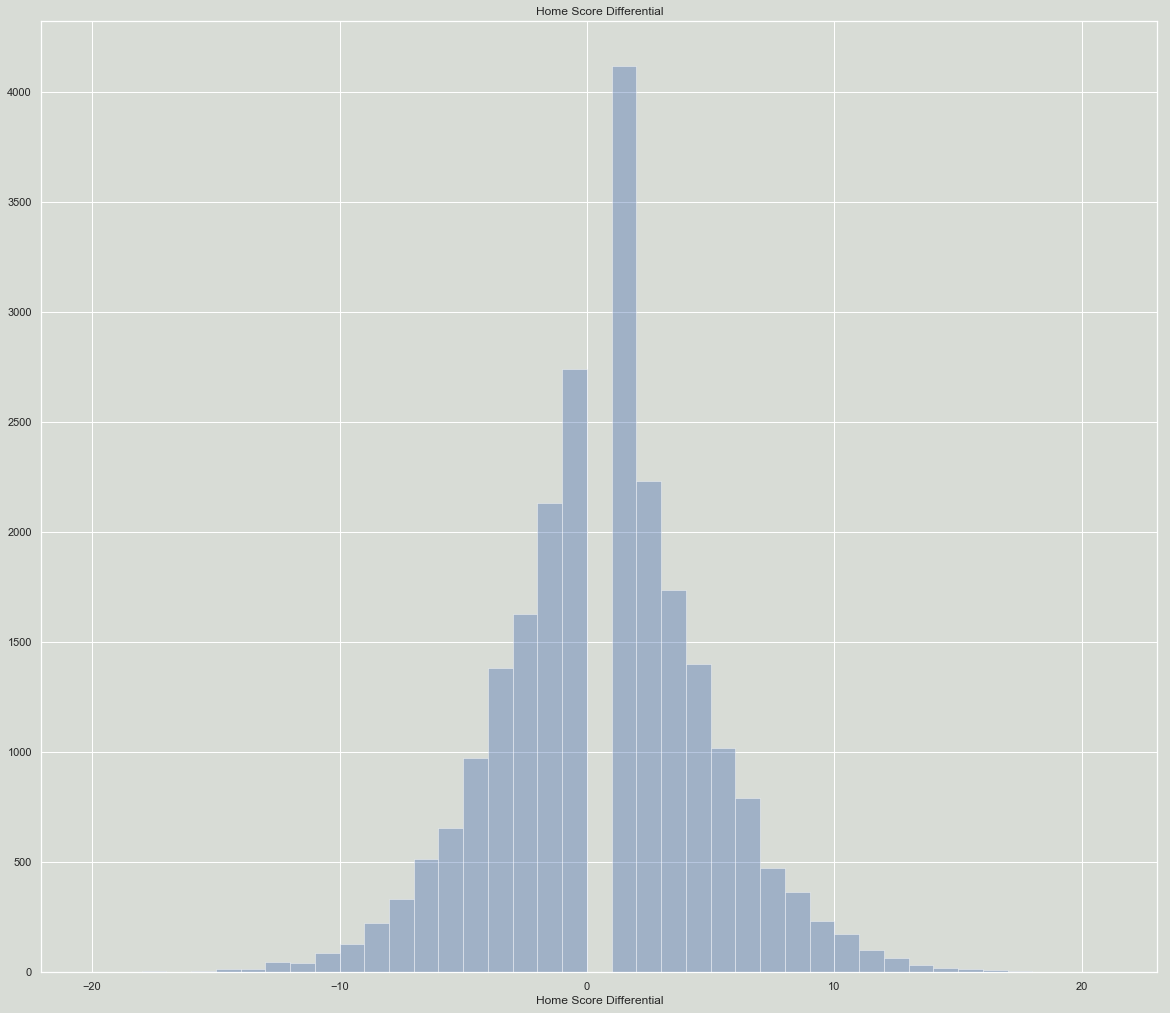

In [111]:
seaborn.distplot(vegasData["Home Score Differential"], kde=False, bins = (max(vegasData["Home Score Differential"]) - min(vegasData["Home Score Differential"])))
plotFunctions.title("Home Score Differential")
plotFunctions.show()

In [14]:
def getOpeningAndClosingImpliedPercent(thisRow, awayOrHome, openingOrClosing):
    if int(thisRow[awayOrHome + " " + openingOrClosing + " Line"]) < 0:
        return round(100 * (abs(int(thisRow[awayOrHome + " " + openingOrClosing + " Line"])) / 
                           (abs(int(thisRow[awayOrHome + " " + openingOrClosing + " Line"])) + 100)), 2)
    else:
        return round(100 * (100 / (int(thisRow[awayOrHome + " " + openingOrClosing + " Line"]) + 100)), 2)
    
for awayOrHome in ["Away", "Home"]:
    for openingOrClosing in ["Opening", "Closing"]:
        vegasData[awayOrHome + " " + openingOrClosing + " Implied Percent"] = vegasData.apply(getOpeningAndClosingImpliedPercent,
                                                                                             args = (awayOrHome,
                                                                                                    openingOrClosing),
                                                                                             axis = 1)

### The House Always Wins

   

In [15]:
print("Average Implied Opening Line Percent: " + str(round(np.mean(np.array(vegasData[["Away Opening Implied Percent", "Home Opening Implied Percent"]])), 2)) + "%")

Average Implied Opening Line Percent: 50.9%


In [16]:
def getOpeningAndClosingTruePercent(thisRow, awayOrHome, openingOrClosing):
    return thisRow[awayOrHome + " " + openingOrClosing + " Implied Percent"] - ((thisRow["Away " + openingOrClosing + " Implied Percent"] + thisRow["Home " + openingOrClosing + " Implied Percent"]- 100) / 2)

for awayOrHome in ["Away", "Home"]:
    for openingOrClosing in ["Opening", "Closing"]:
        vegasData[awayOrHome + " " + openingOrClosing + " True Percent"] = vegasData.apply(getOpeningAndClosingTruePercent,
                                                                                             args = (awayOrHome,
                                                                                                    openingOrClosing),
                                                                                             axis = 1)

In [17]:
print("Average True Opening Line Percent: " + str(round(np.mean(np.array(vegasData[["Away Opening True Percent", "Home Opening True Percent"]])), 2)) + "%")

Average True Opening Line Percent: 50.0%


There are a number of ways to evaluate how well Vegas did at predicting games. We'll start with simple accuracy: how often did a team with an assigned probability of greater than 50% win?

We'll also need to erase any games in which teams were given a 50/50 chance of winning.

In [18]:
vegasData = vegasData.loc[vegasData["Away Opening True Percent"] != 50]
vegasData = vegasData.loc[vegasData["Away Closing True Percent"] != 50]

def getCorrectPrediction(thisRow, openingOrClosing):
    if float(thisRow["Away " + openingOrClosing + " True Percent"]) > 50:
        if thisRow["Away Win"] == True:
            return True
        else:
            return False
    else:
        if thisRow["Home Win"] == True:
            return True
        else:
            return False
        
for openingOrClosing in ["Opening", "Closing"]:
        vegasData["Correct " + openingOrClosing + " Prediction"] = vegasData.apply(getCorrectPrediction,
                                                                                             args = (openingOrClosing,),
                                                                                             axis = 1)
        
print("Correct opening line prediction percent 2009-2018: " + str(round(100 * (sum(np.array(vegasData["Correct Opening Prediction"])) / len(vegasData)), 2)) + "%")
print("Correct closing line prediction percent 2009-2018: " + str(round(100 * (sum(np.array(vegasData["Correct Closing Prediction"])) / len(vegasData)), 2)) + "%")

Correct opening line prediction percent 2009-2018: 57.43%
Correct closing line prediction percent 2009-2018: 57.69%


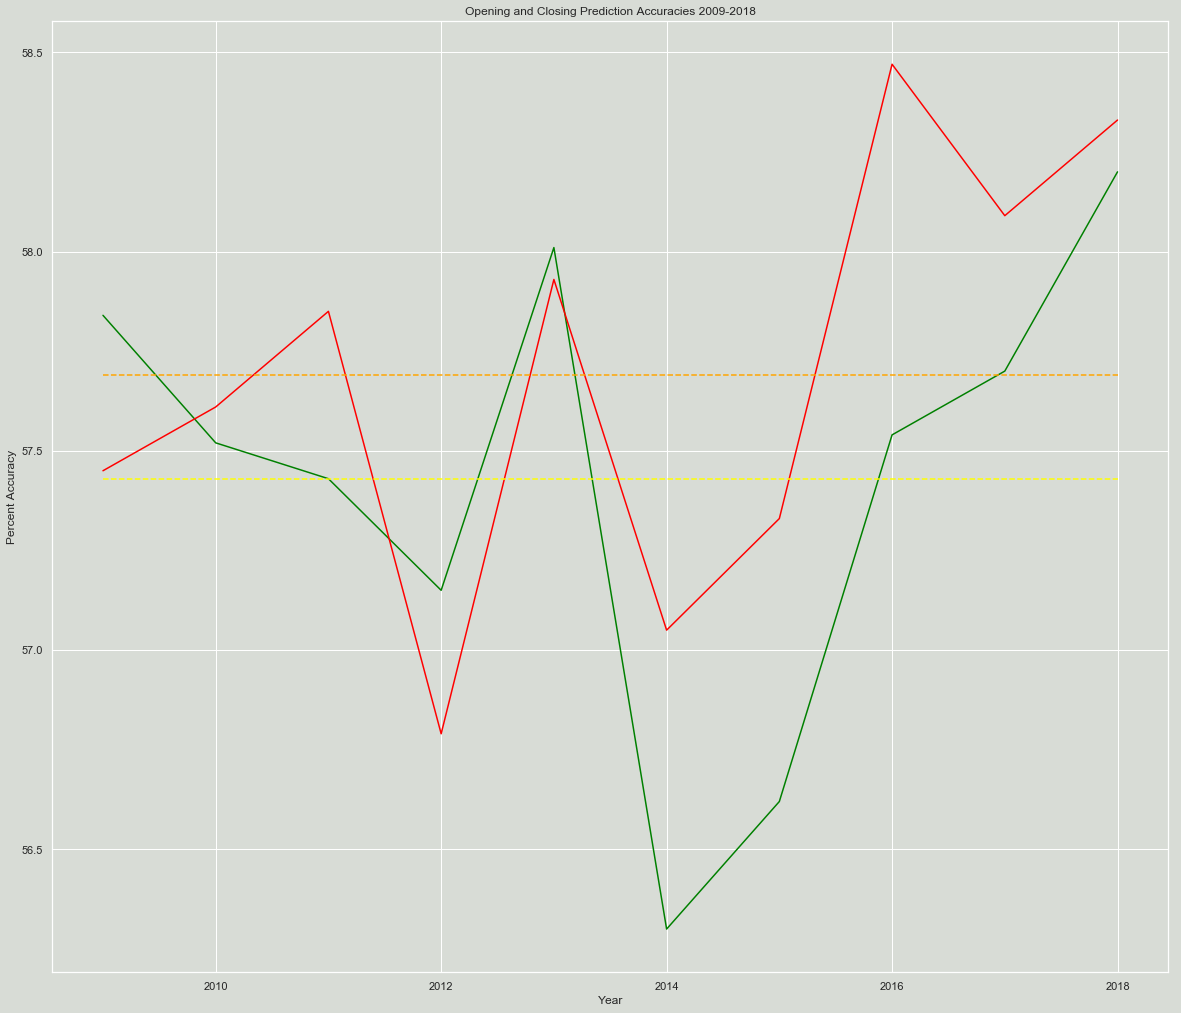

In [103]:
seasonOpeningPercents = []
seasonClosingPercents = []
for thisSeason in range(2009, 2019):
    seasonOpeningPercents.append(round(100 * (sum(np.array(vegasData.loc[vegasData["Season"] == thisSeason]["Correct Opening Prediction"])) / len(vegasData.loc[vegasData["Season"] == thisSeason])), 2))
    seasonClosingPercents.append(round(100 * (sum(np.array(vegasData.loc[vegasData["Season"] == thisSeason]["Correct Closing Prediction"])) / len(vegasData.loc[vegasData["Season"] == thisSeason])), 2))
    
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), seasonOpeningPercents, color = "green")
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), seasonClosingPercents, color = "red")
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), np.full((len(seasonOpeningPercents),), 57.43), color = "yellow", linestyle = "dashed")
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), np.full((len(seasonOpeningPercents),), 57.69), color = "orange", linestyle = "dashed")
plotFunctions.title("Opening and Closing Prediction Accuracies 2009-2018")
plotFunctions.xlabel("Year")
plotFunctions.ylabel("Percent Accuracy")
plotFunctions.show()

   The market's opening and closing lines were fairly random in the first few years of the sample; on a few years the closing line had higher predictive power than the opening line, and on other years the opening line held a clearer crystal ball. However, from 2014 onwards, the closing line was able to more accurately predict the outcome of a ball game than the opening line.
   It's difficult to evaluate if 

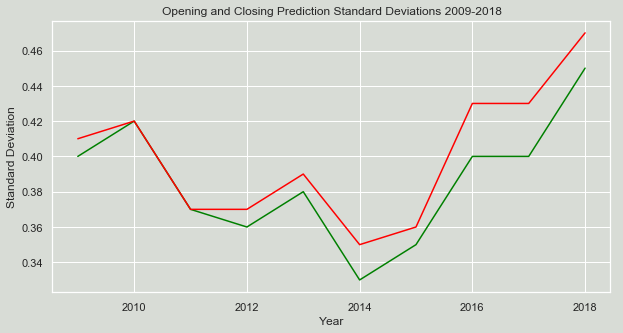

In [60]:
seasonOpeningDeviation = []
seasonClosingDeviation = []
for thisSeason in range(2009, 2019):
    seasonOpeningDeviation.append(round(100 * (np.std(np.array(vegasData.loc[vegasData["Season"] == thisSeason][["Away Opening True Percent", "Home Opening True Percent"]])) / len(vegasData.loc[vegasData["Season"] == thisSeason])), 2))
    seasonClosingDeviation.append(round(100 * (np.std(np.array(vegasData.loc[vegasData["Season"] == thisSeason][["Away Closing True Percent", "Home Closing True Percent"]])) / len(vegasData.loc[vegasData["Season"] == thisSeason])), 2))
    
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), seasonOpeningDeviation, color = "green")
plotFunctions.plot(np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]), seasonClosingDeviation, color = "red")
plotFunctions.title("Opening and Closing Prediction Standard Deviations 2009-2018")
plotFunctions.xlabel("Year")
plotFunctions.ylabel("Standard Deviation")
plotFunctions.show()

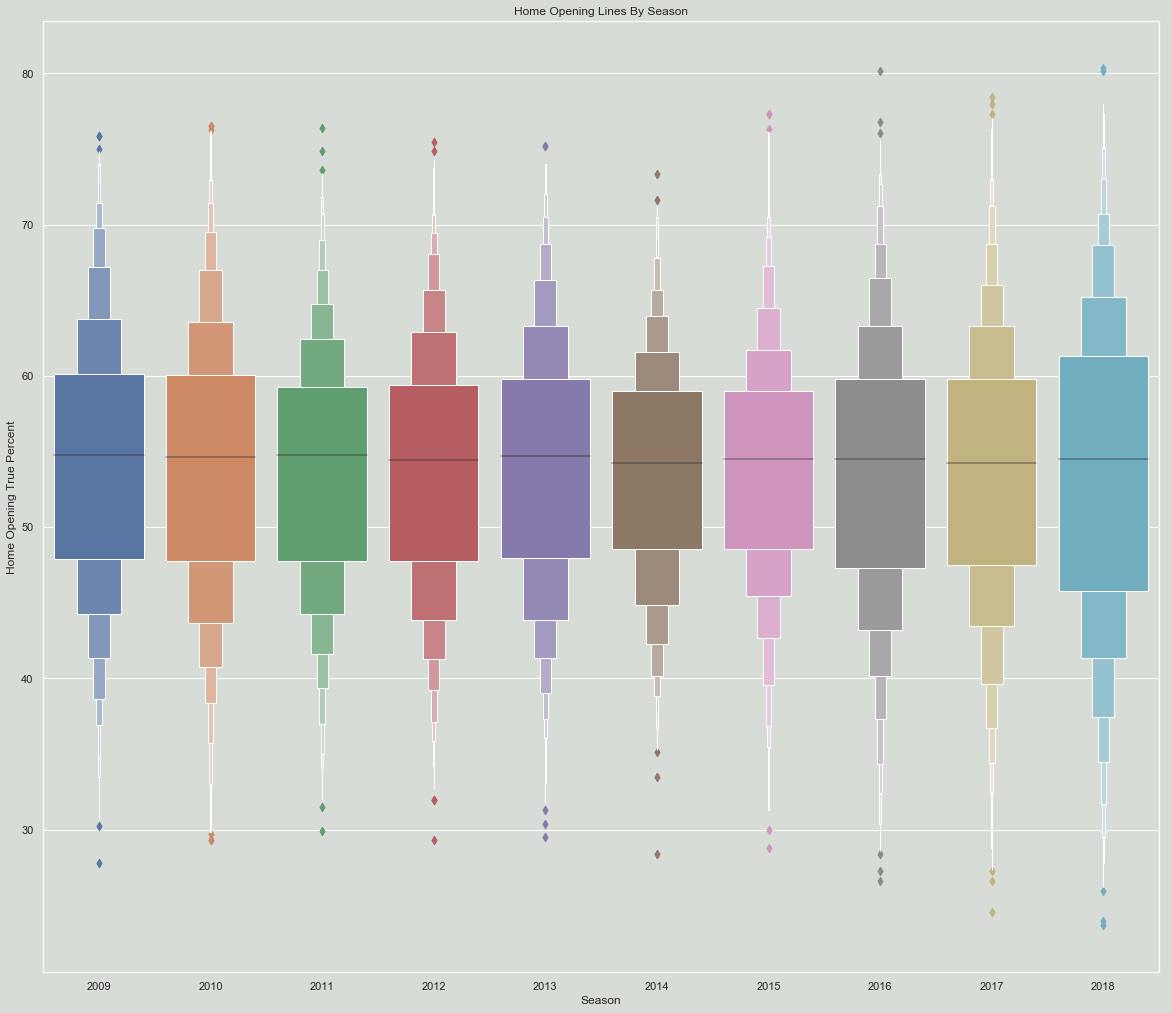

In [98]:
seaborn.boxenplot(x="Season", y="Home Opening True Percent", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.title("Home Opening Lines By Season")
plotFunctions.show()

In [43]:
def getMonth(thisRow):
    if str(thisRow["Date"]).split("/")[0] == "3":
        return "March/April"
    elif str(thisRow["Date"]).split("/")[0] == "4":
        return "March/April"
    elif str(thisRow["Date"]).split("/")[0] == "5":
        return "May"
    elif str(thisRow["Date"]).split("/")[0] == "6":
        return "June"
    elif str(thisRow["Date"]).split("/")[0] == "7":
        return "July"
    elif str(thisRow["Date"]).split("/")[0] == "8":
        return "August"
    elif str(thisRow["Date"]).split("/")[0] == "9":
        return "September"
    elif str(thisRow["Date"]).split("/")[0] == "10":
        return "October/November"
    elif str(thisRow["Date"]).split("/")[0] == "11":
        return "October/November"
    
vegasData["Month"] = vegasData.apply(getMonth, axis = 1)

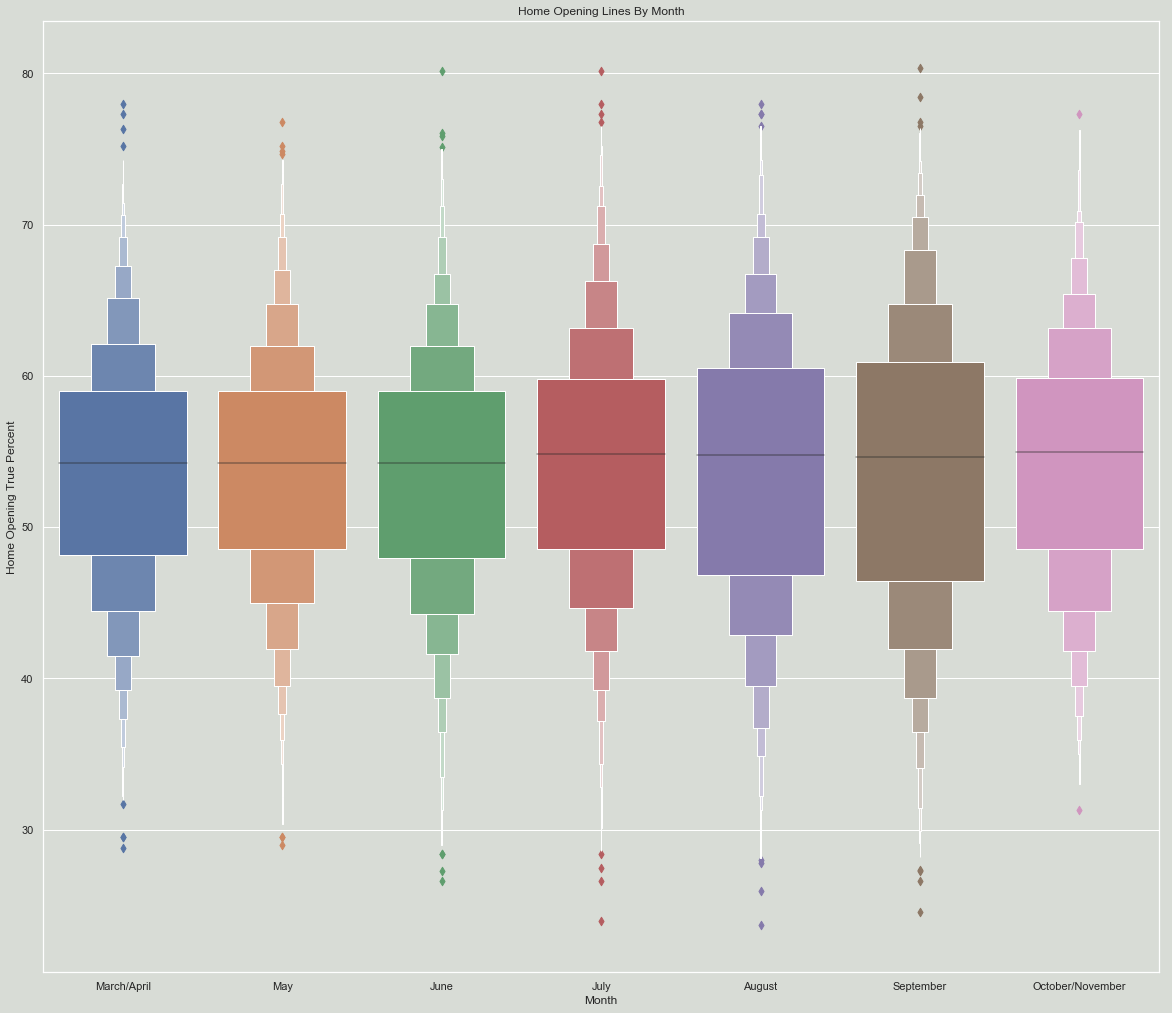

In [96]:
seaborn.boxenplot(x="Month", y="Home Opening True Percent", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.title("Home Opening Lines By Month")
plotFunctions.show()

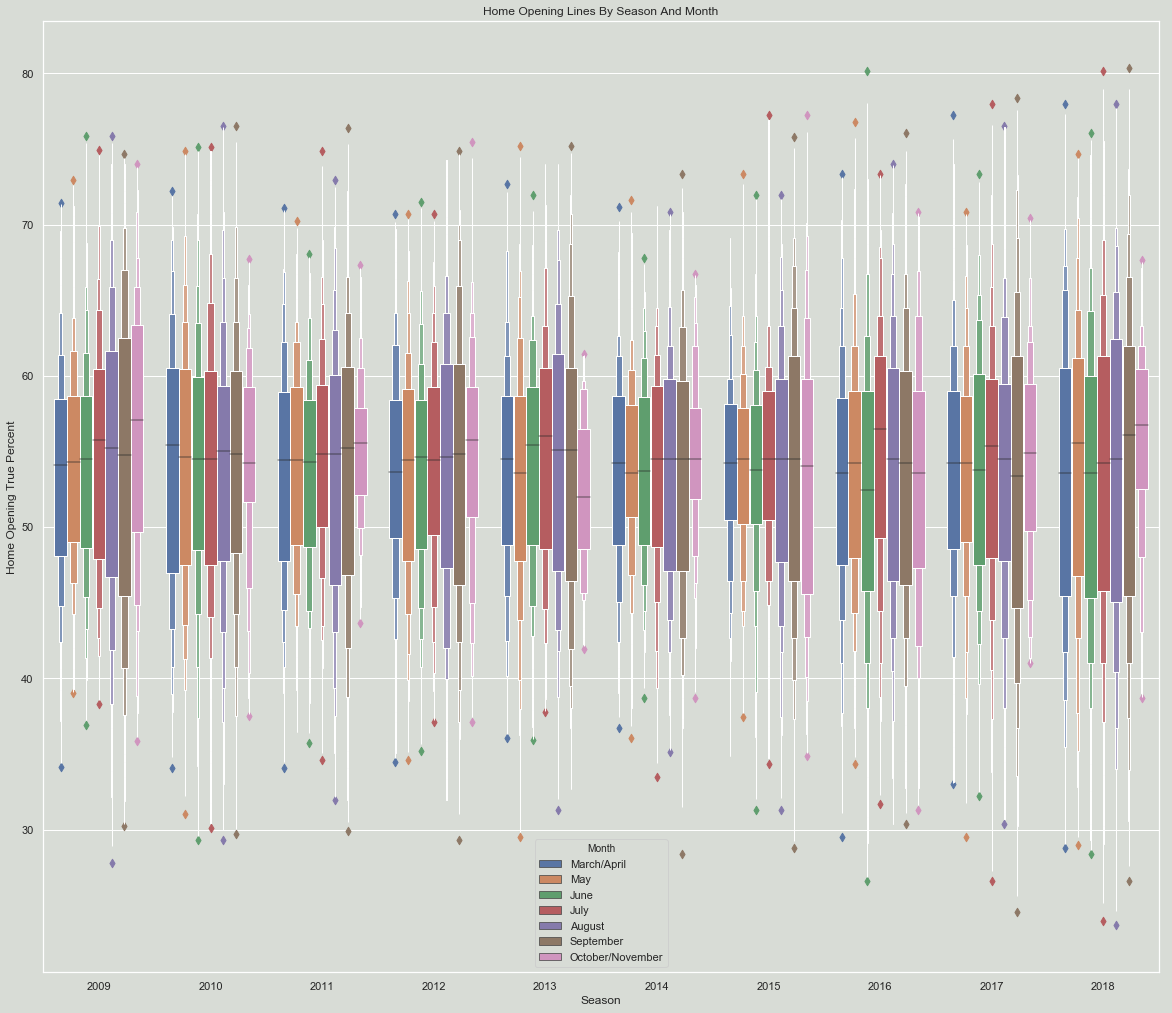

In [95]:
seaborn.boxenplot(x="Season", y="Home Opening True Percent", hue = "Month", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.title("Home Opening Lines By Season And Month")
plotFunctions.rcParams["figure.figsize"] = [20, 17.5]
plotFunctions.show()

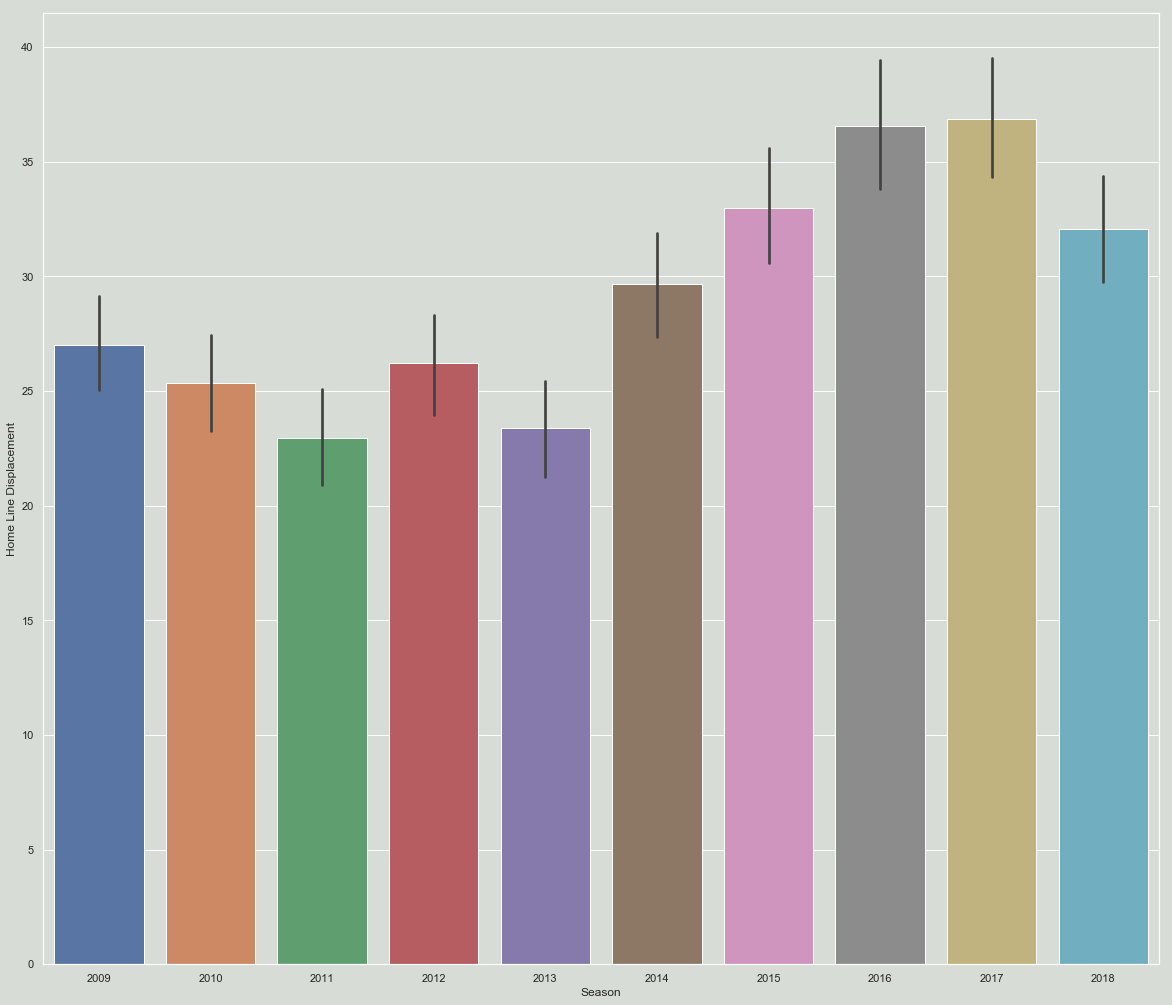

In [99]:
def getTotalDisplacementLine(thisRow, awayOrHome):
    return abs(int(thisRow[awayOrHome + " Opening Line"]) - int(thisRow[awayOrHome + " Closing Line"]))

awayOrHome = "Home"
vegasData[awayOrHome + " Line Displacement"] = vegasData.apply(getTotalDisplacementLine, args = (awayOrHome,), axis = 1)
seaborn.barplot(x = "Season", y = "Home Line Displacement", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.show()

In [85]:
def categorizeImpliedPercent(thisRow, awayOrHome):
    if float(thisRow[awayOrHome + " Opening True Percent"]) < 33.33:
        return "< 33.33%"
    elif (float(thisRow[awayOrHome + " Opening True Percent"]) >= 33.33) & (float(thisRow[awayOrHome + " Opening True Percent"]) < 45.45):
        return "33.33% - 45.44%"
    elif (float(thisRow[awayOrHome + " Opening True Percent"]) >= 45.45) & (float(thisRow[awayOrHome + " Opening True Percent"]) < 54.55):
        return "45.45% - 54.54%"
    elif (float(thisRow[awayOrHome + " Opening True Percent"]) >= 54.55) & (float(thisRow[awayOrHome + " Opening True Percent"]) <= 66.67):
        return "54.55% - 66.67%"
    else:
        return "> 66.67"
    
def categorizeLines(thisRow, awayOrHome):
    if float(thisRow[awayOrHome + " Opening Line"]) > 200:
        return "> 200"
    elif (float(thisRow[awayOrHome + " Opening Line"]) <= 200) & (float(thisRow[awayOrHome + " Opening Line"]) > 120):
        return "200 - 121"
    elif (float(thisRow[awayOrHome + " Opening Line"]) <= 120) & (float(thisRow[awayOrHome + " Opening Line"]) > -119):
        return "120 - -119"
    elif (float(thisRow[awayOrHome + " Opening Line"]) <= -120) & (float(thisRow[awayOrHome + " Opening Line"]) > -200):
        return "-120 - -200"
    else:
        return "< -200"
    
def getTotalDisplacementImpliedPercent(thisRow, awayOrHome):
    return abs(float(thisRow[awayOrHome + " Opening Implied Percent"]) - float(thisRow[awayOrHome + " Closing Implied Percent"]))

awayOrHome = "Home"
vegasData["Categorized " + awayOrHome + " Opening Implied Percent"] = vegasData.apply(categorizeImpliedPercent, args = (awayOrHome,), axis = 1)
vegasData["Categorized " + awayOrHome + " Opening Line"] = vegasData.apply(categorizeLines, args = (awayOrHome,), axis = 1)
vegasData[awayOrHome + " Implied Percent Displacement"] = vegasData.apply(getTotalDisplacementImpliedPercent, args = (awayOrHome,), axis = 1)

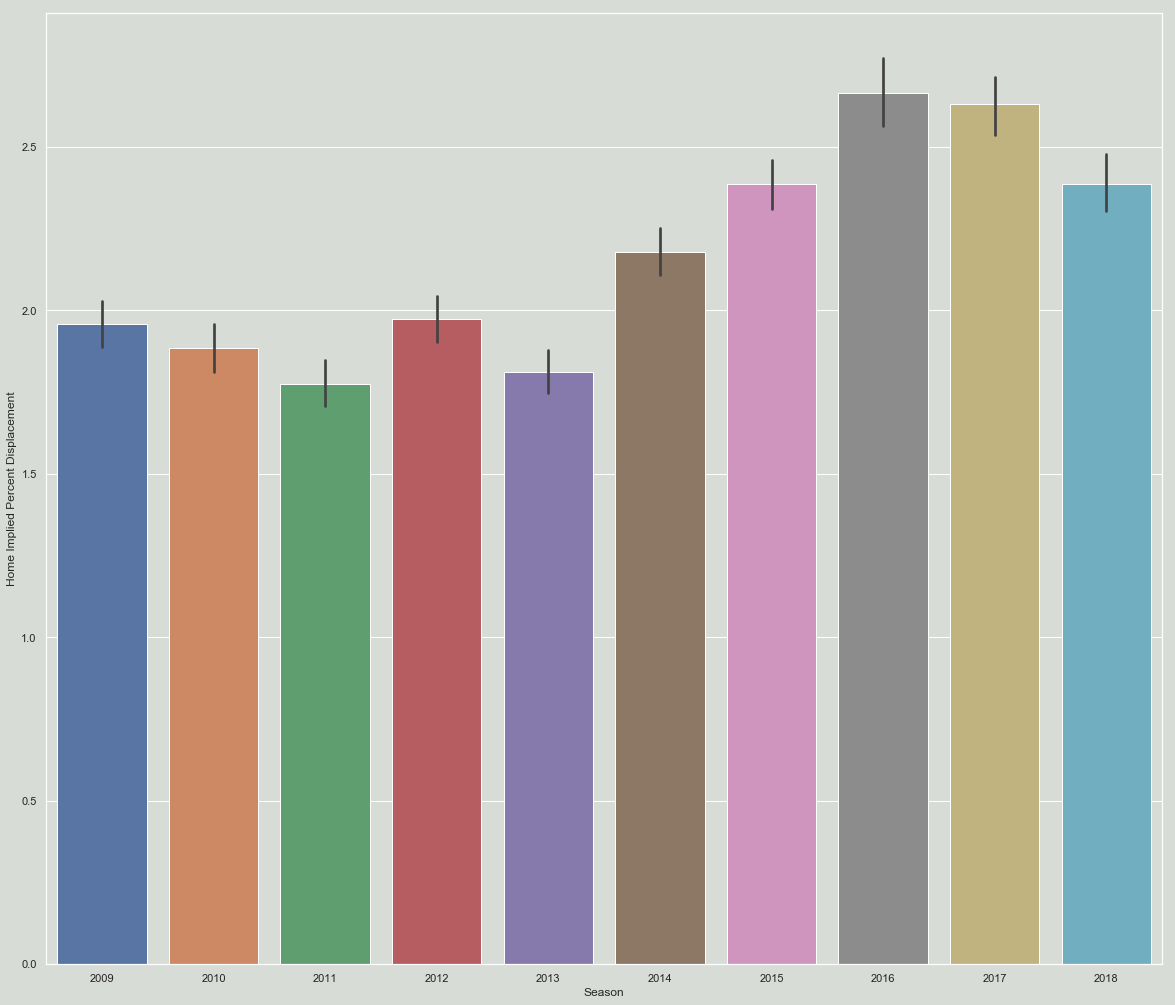

In [100]:
seaborn.barplot(x = "Season", y = "Home Implied Percent Displacement", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.show()

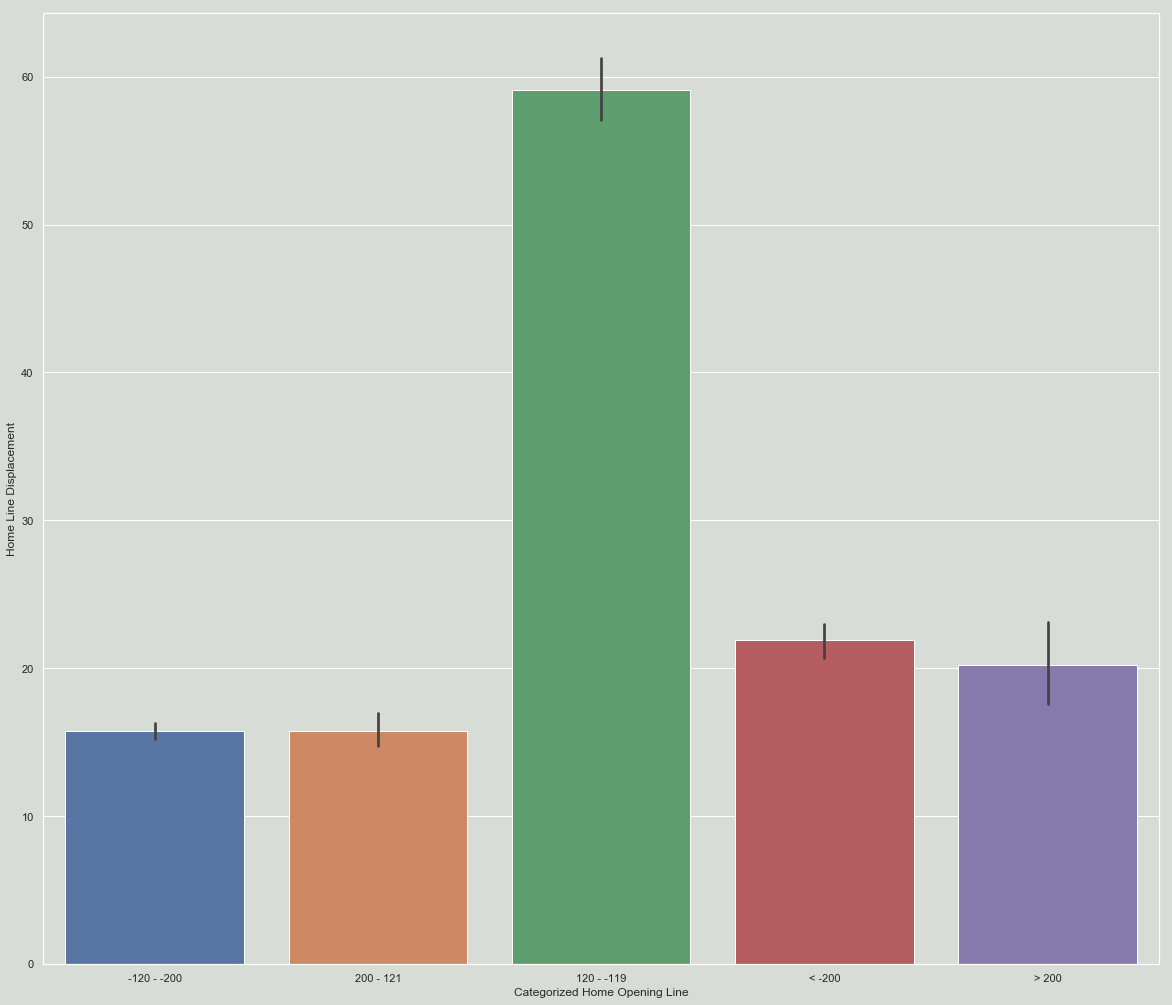

In [101]:
seaborn.barplot(x = "Categorized Home Opening Line", y = "Home Line Displacement", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.show()

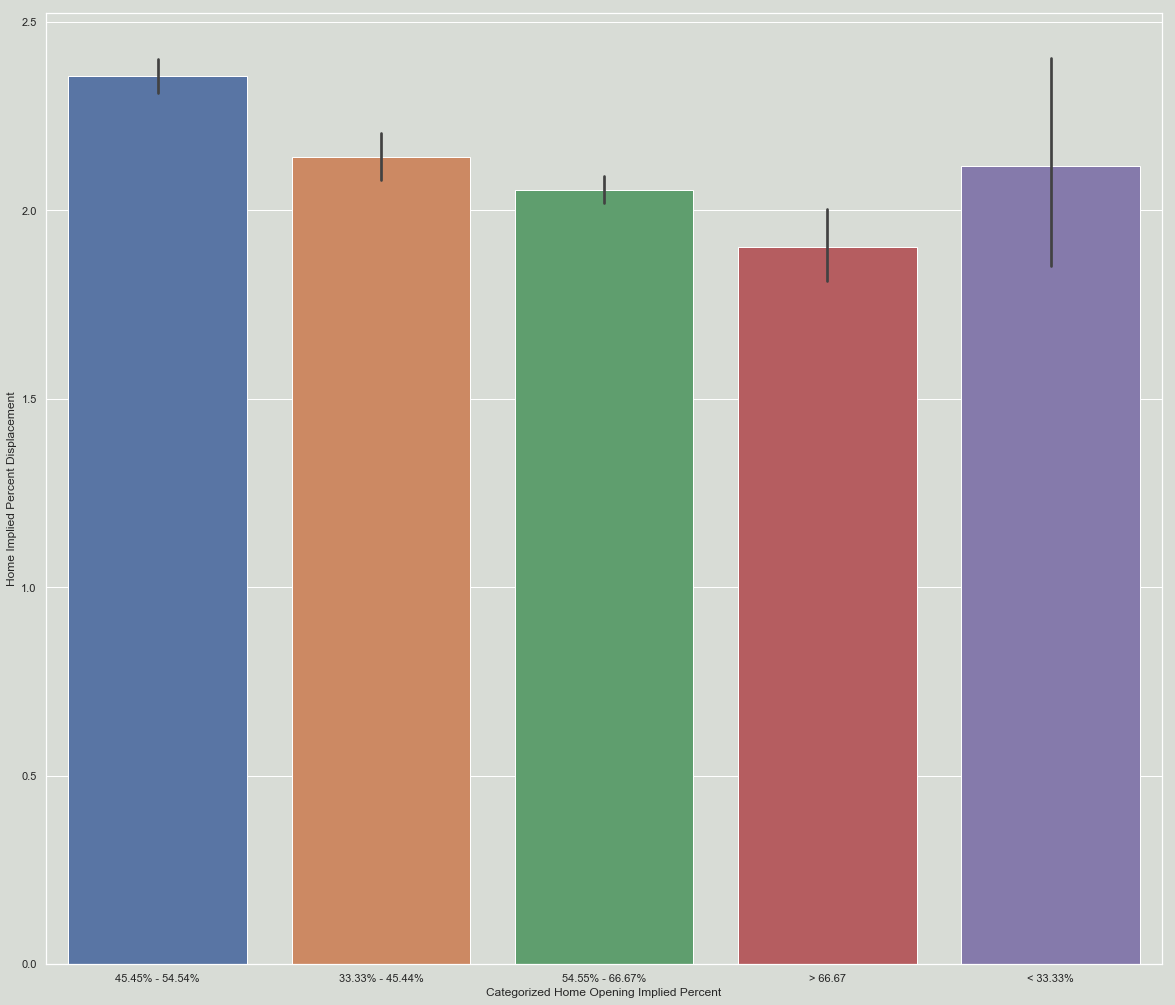

In [102]:
seaborn.barplot(x = "Categorized Home Opening Implied Percent", y = "Home Implied Percent Displacement", data = vegasData.loc[vegasData["Home Opening True Percent"] < 90])
plotFunctions.show()